In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import python.load_model_zone as plmz
import python.load_model_multizone as plm
from python.utils import project_path, zone_names

In [2]:
# Read predictors
climate_filenames = {"tgw": "zonal_T2C_historical_1980_2019"}
climate_data = "tgw"
temp_data_path = f"{project_path}/data/climate/{climate_data}/{climate_filenames[climate_data]}.csv"

# Read load data
load_data_path = f"{project_path}/data/nyiso/historical_load/combined/historical_load.csv"

# Load data
temp_data, load_data = plm.load_and_prepare_data(temp_data_path, load_data_path)

### EDA

In [3]:
# Pivot
load_data_pivot = load_data.pivot(columns='zone', index='time', values='load_MW')

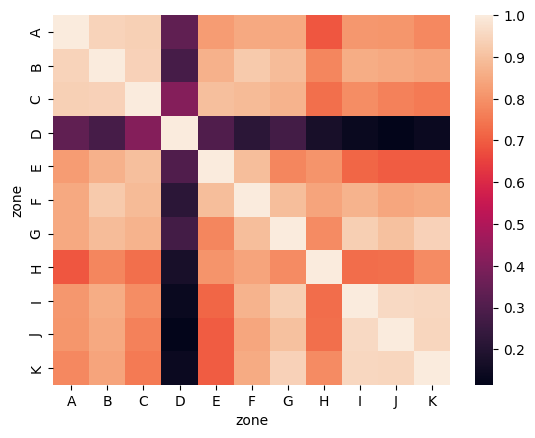

In [8]:
fig, ax = plt.subplots()
sns.heatmap(load_data_pivot.corr(), ax=ax)
plt.show()

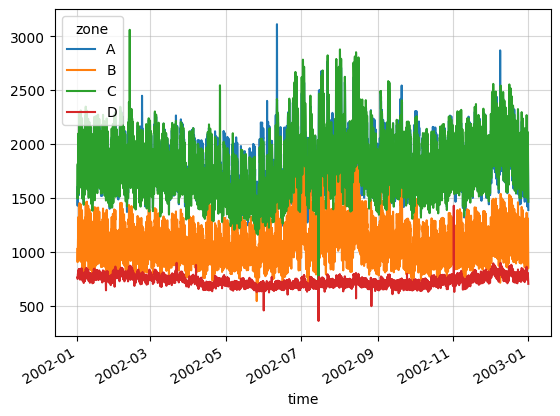

In [10]:
fig, ax = plt.subplots()
load_data_pivot[['A', 'B', 'C', 'D']].iloc[:365*24].plot(ax=ax)
ax.grid(alpha=0.5)
plt.show()

### Multi-zone model

In [ ]:
# Create and train a multi-zone predictor
# predictor = plm.MultiZoneLoadPredictor(model_type="random_forest")

# Train model
from sklearn.neural_network import MLPRegressor

predictor = plm.MultiZoneLoadPredictor(model=MLPRegressor(hidden_layer_sizes=(100,100),
                                                          early_stopping=True,
                                                          max_iter=5000))

metrics = predictor.train(temp_data, load_data, test_split=[2016])

# Save model
filepath = f"{project_path}/data/models/load_model_{climate_data}_multizone_NN.pkl"
predictor.save_model(filepath)

In [ ]:
# Print evaluation metrics
for metric, value in metrics['overall'].items():
    print(f"{metric}: {value:.4f}")

In [ ]:
# Plot evaluation metrics by zone
metric_type = 'r2'
    
# Extract zone names
zones = list(metrics.keys())

# Extract train and test values for the specified metric
train_values = [metrics[zone][f"{metric_type}_train"] for zone in zones]
test_values = [metrics[zone][f"{metric_type}_test"] for zone in zones]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Set width of bars and positions
bar_width = 0.35
x = np.arange(len(zones))

# Create the grouped bars
train_bars = ax.bar(x - bar_width/2, train_values, bar_width, label=f'Train {metric_type.upper()}')
test_bars = ax.bar(x + bar_width/2, test_values, bar_width, label=f'Test {metric_type.upper()}')

# Set labels, title and legend
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel(metric_type.upper(), fontsize=12)
ax.set_title(f'{metric_type.upper()} by Zone', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(zones)
ax.legend()

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

In [ ]:
# Load model
predictor = plm.MultiZoneLoadPredictor()
predictor.load_model(f"{project_path}/data/models/load_model_{climate_data}_multizone_NN.pkl")

In [ ]:
predictor

In [ ]:
predictor.plot_results('A')

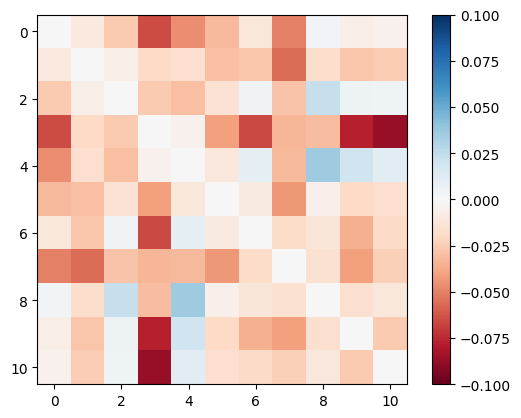

In [29]:
# Check correlation differences
corrdiff = predictor.test_results['y_true'].corr().to_numpy() - pd.DataFrame(predictor.test_results['y_pred']).corr().to_numpy()

fig, ax = plt.subplots()
image = ax.imshow(corrdiff, vmin=-0.1, vmax=0.1, cmap='RdBu')
plt.colorbar(image)
plt.show()

### Zonal models

In [31]:
# Create a load predictor
zonal_predictor = plmz.LoadPredictor() # Default: RandomForestRegressor

# from sklearn.neural_network import MLPRegressor
# predictor = plm.LoadPredictor(model=MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42))

In [32]:
# # Loop through all
# for zone in zone_names:
#     print(f"Now modeling: {zone}")
#     # Train
#     model = predictor.train(temp_data, load_data, zone, test_split=[2016])
#     # Show results
#     filepath = f"{project_path}/figs/load_model_{climate_data}_zone{zone}.pdf"
#     predictor.plot_results(zone, filepath=filepath)
#     # Save model
#     filepath=f"{project_path}/data/models/load_model_{climate_data}_zone{zone}.pkl"
#     predictor.save_model(zone, filepath=filepath)

In [33]:
for zone in zone_names:
    filepath=f"{project_path}/data/models/load_model_{climate_data}_zone{zone}.pkl"
    zonal_predictor.load_model(zone, filepath = filepath)

Model for zone A loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneA.pkl
Model for zone B loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneB.pkl
Model for zone C loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneC.pkl
Model for zone D loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneD.pkl
Model for zone E loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneE.pkl
Model for zone F loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneF.pkl
Model for zone G loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneG.pkl
Model for zone H loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneH.pkl
Model for zone I loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_zoneI.pkl
Model for zone J loaded from /home/fs01/dcl257/projects

In [49]:
print("\nBy Zone:")
for zone in predictor.zone_columns:
    print(f"\nZone {zone}:")
    for metric in ['train_r2', 'test_r2']:
        print(f"  {metric}: {zonal_predictor.zone_models[zone]['metrics'][metric]}")


By Zone:

Zone A:
  train_r2: 0.9356197600237405
  test_r2: 0.431593111331694

Zone B:
  train_r2: 0.9295739117642258
  test_r2: 0.45974918836319134

Zone C:
  train_r2: 0.9324817220362195
  test_r2: 0.3937280588686408

Zone D:
  train_r2: 0.9938219556882089
  test_r2: 0.6636331897861913

Zone E:
  train_r2: 0.9393521680304869
  test_r2: 0.36277739637509

Zone F:
  train_r2: 0.9349472362452553
  test_r2: 0.44170775430665665

Zone G:
  train_r2: 0.940633839340587
  test_r2: 0.5523183452347395

Zone H:
  train_r2: 0.9499927733265421
  test_r2: 0.45034343764516793

Zone I:
  train_r2: 0.9462769990924754
  test_r2: 0.5875547898860385

Zone J:
  train_r2: 0.9389805910633277
  test_r2: 0.5800722893396236

Zone K:
  train_r2: 0.9541427993396298
  test_r2: 0.6789042237906777


In [34]:
# Gather all predictions
df_pred = []
for zone in zone_names:
    df_pred.append(zonal_predictor.zone_models[zone]['test_results'].set_index('datetime')[['y_pred']].rename(columns={'y_pred':zone}))

df_pred = pd.concat(df_pred, axis=1)

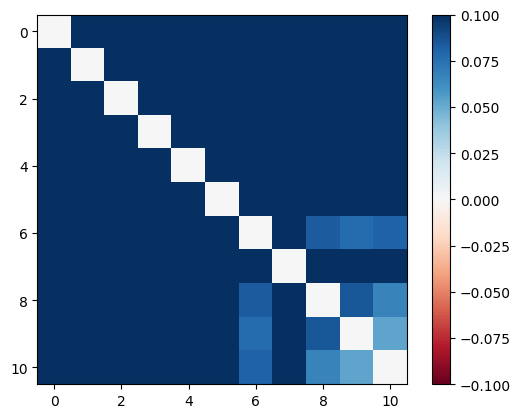

In [43]:
# Check correlational differences
load_data_pivot = load_data[load_data['time'].dt.year == 2016].pivot(index='time', columns='zone')

fig, ax = plt.subplots()
image = ax.imshow(load_data_pivot.corr().to_numpy() - df_pred.corr().to_numpy(), vmin=-0.1, vmax=0.1, cmap='RdBu')
plt.colorbar(image)
plt.show()